# [E-06] 영화리뷰 텍스트 감성분석하기
***
## 목차
### 1. LMS 따라하기
### 2. IMDB 영화리뷰 따라하기
### 3. 프로젝트 : 네이버 영화리뷰 감성분석
### 4. 회고
***

> 영화리뷰에 대한 감성분석을 통해 자연어 처리, RNN 을 배워보자. CNN 으로도 자연어 처리가 가능하다
***

### 1.1 LMS 따라하기_텍스트를 숫자로 표현하는 방법

In [1]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [2]:
# 모든 문장을 단어로 쪼개서 딕셔너리를 만들자
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [3]:
# 텍스트를 숫자로 바꾸려면 위의 딕셔너리가 {텍스트:인덱스} 구조 여야한다,
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [4]:
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [6]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [7]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [8]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


### 1.2 LMS 따라하기_Embedding 레이어의 등장.
> 단어의 의미를 나타내는 벡터를 훈련 가능한 파라미터로 놓고 이를 딥러닝을 통해 학습, 최적화 한다.
- input 문장의 길이가 일정해야 한다.

In [10]:
# 아래 코드는 그대로 실행하시면 에러가 발생할 것입니다. 

import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
output = embedding(raw_inputs)
print(output)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [11]:
# 앞선 문장의 길이는 4,4,5 였다.
# 텐서플로의 tf.keras.preprocessing.sequence.pad_sequences 함수로 <PAD> 를 준다.
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


In [12]:
vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype=object)
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[-3.29986215e-05  4.85595502e-02  2.00428702e-02  2.21046247e-02]
  [ 1.41698755e-02  1.54452436e-02 -2.55142581e-02 -1.07015967e-02]
  [ 3.03592347e-02  2.98679359e-02  8.29406828e-03  3.10229324e-02]
  [ 3.95267494e-02  2.21518986e-02 -4.50669304e-02  3.91530059e-02]
  [-2.89646741e-02 -2.75485758e-02 -4.92882840e-02  3.05444002e-03]]

 [[-3.29986215e-05  4.85595502e-02  2.00428702e-02  2.21046247e-02]
  [ 1.41698755e-02  1.54452436e-02 -2.55142581e-02 -1.07015967e-02]
  [-2.27639563e-02 -2.96230074e-02 -3.80906574e-02  3.32366936e-02]
  [ 2.58850791e-02  1.70723312e-02  1.63183473e-02 -4.06875238e-02]
  [-2.89646741e-02 -2.75485758e-02 -4.92882840e-02  3.05444002e-03]]

 [[-3.29986215e-05  4.85595502e-02  2.00428702e-02  2.21046247e-02]
  [ 1.59494914e-02 -9.21032578e-03 -1.98549032e-03  5.22224978e-03]
  [ 1.41698755e-02  1.54452436e-02 -2.55142581e-02 -1.07015967e-02]
  [ 3.03592347e-02  2.98679359e-02  8.29406828e-03  3.10229324e-02]
  [-1.85740590e-02  3.26963179e-0

- 위에서 output 의 shape 3,5,4 는 각각 문장수, 단어 길이, 임베딩 벡터의 차원수 를 의미한다.

### 1.3 LMS 따라하기_시퀀스 데이터, RNN
> Recurrent Neural Network, 순환신경망으로 시퀀스 형태의 데이터 처리 최적의 모델.
- 음성데이터, 문장 등
- 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine으로 설계되었다.


In [13]:
# RNN 모델로 앞의 텍스트 데이터를 처리하는 예제코드
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


### 1.4 LMS 따라하기_CNN으로 텍스트 처리하기
> 1-D CNN 으로 텍스트를 처리 할 수 있다.
- 문장 전체를 한꺼분에 한 방향으로 길이 7짜리 필터로 스캔.
- 7단어 이내의 특징을 추출, 문장을 분류하는 방식.
- CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르다.

In [15]:
# 1-D CNN 모델
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [16]:
# GlobalMaxPooling1D() 레이어 하나만 사용
# 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출 하여 긍정/부정 평가하는 방식.
# 의외로 성능이 잘 나올 수도 있다.

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


> 이 외에도 1-D CNN 과 RNN 을 섞어 사용한다거나, FNN(Feed Forward Network) 레이어만 으로 구성, Transformer 레이어 사용 등 다양한 시도가 가능하다.

### 2.1 IMDB 영화리뷰 감성분석_IMDB 데이터셋 분석
> 5만개 영어, 영화리뷰 텍스트로 구성. 긍정 1, 부정 0 라벨. 2만5천개 훈련용, 2만5천개 테스트용. tf keras 에 포함.

In [17]:
imdb = tf.keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

17473536/17464789 [==============================] - 0s 0us/step
훈련 샘플 개수: 25000, 테스트 개수: 25000


- num_word = 1만 으로 load_data 하였다. 1만개 word_to_index 딕셔너리가 생성된 형태로 데이터 셋이 생성된다.

In [18]:
# 데이터 확인
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


- 숫자로 encode 된 텍스트 데이터이다.
- encode 되었으므로, IMDB는 딕셔너리와 함께 제공한다.

In [19]:
# 인코딩에 사용한 딕셔너리 받기.
word_to_index = imdb.get_word_index() # word to index 받기
index_to_word = {index:word for word, index in word_to_index.items()} #  index to word로 변환
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

1654784/1641221 [==============================] - 0s 0us/step
the
1


- tf 튜토리얼 가이드에 맞게 보정.
- word_to_index는 IMDB 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차순 정렬되어 있다.

In [23]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [24]:
# decode 가 정상적으로 작동하는지 확인
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨 : ', y_train[0])

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

- pad_sequences 로 문장길이를 통일 하자.
- 문장의 최대 길이, maxlen 값 또한, 전체 모델의 성능에 영향을 미친다.
- 적절한 길이를 찾기 위해서 전체데이터셋의 분포를 확인하자

In [25]:
total_data_text = list(x_train) + list(x_test) # 전체 문장을 담는다. 
# 텍스트 데이터 문장길이의 리스트를 생성한 후 
num_tokens = [len(tokens) for tokens in total_data_text] #전체 문장에서 각 문장의 길이를 담은 리스트 생성.
num_tokens = np.array(num_tokens) # np 연산을 위해, np.array로 변환.

# 문장길이의 편균, max, 표준편차를 계산.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


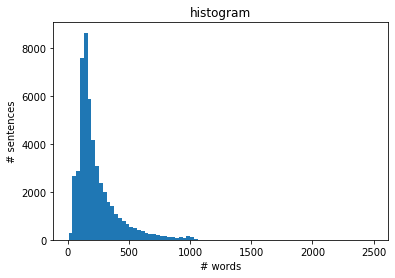

In [36]:
# 히스토 그램으로 문장길이 분포 시각화
from matplotlib import pyplot as plt 

plt.hist(num_tokens, bins = 80) 
plt.title("histogram") 
plt.xlabel('# words') 
plt.ylabel('# sentences')
plt.show()

- maxlen을 580으로 적용하자.
- 패딩방식(post/뒤, pre/앞)에 따라 성능차이가 발생한다. 직접 결과를 비교해 보자.


In [37]:
# 훈련셋과 테스트 셋에 maxlen으로 자르고, 패팅을 주자.
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


***
[패딩 post 와 pre 중 무엇이 유리할까?]
> RNN 은 입력데이터가 순차적으로 처리된다. 따라서 마지막 입력이 최정 state 값에 가장 많은 영향을 미치게 된다. 그러므로 마지막 입력이 무의미한 패딩으로 채워지는 것은 비효율적이다. 결론적으로 'pre' 패딩이 훨씬 유리하며, 10% 이상 테스트 성능 차이를 보이게 된다.

### 2.2 IMDB 영화리뷰 감성분석_딥러닝 모델 설계와 훈련
> RNN 모델을 설계하자

In [38]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))# state 벡터 차원서 8, 변경가능
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))#최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


- 훈련데이터 2만5천중 1만건을 검증셋으로 분리하자.
- 적절한 검증셋은 몇개 일지 고민해보자.

In [39]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


- 모델 학습하기

In [40]:
# 옵티마이저 아담, 로스함수는 2진 분류이므로 바이너리 크로스엔트로피 사용.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 21s 48ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 2/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6928 - accuracy: 0.5113 - val_loss: 0.6930 - val_accuracy: 0.5011
Epoch 3/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6924 - accuracy: 0.5125 - val_loss: 0.6929 - val_accuracy: 0.5016
Epoch 4/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6914 - accuracy: 0.5161 - val_loss: 0.6926 - val_accuracy: 0.5024
Epoch 5/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6877 - accuracy: 0.5171 - val_loss: 0.6908 - val_accuracy: 0.5063
Epoch 6/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6800 - accuracy: 0.5304 - val_loss: 0.6901 - val_accuracy: 0.5093
Epoch 7/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6757 - accuracy: 0.5343 - val_loss: 0.6892 - val_accuracy: 0.5106
Epoch 8/20
3

- 학습이 끝났다. 테스트 셋으로 평가해 보자.

In [41]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 5s - loss: 0.6972 - accuracy: 0.5146
[0.6972497701644897, 0.5146399736404419]


- 0.5146 의 정확도
- history.history 에 훈련셋 검증셋의 매 에폭 마다 loss와 acc 등 이 저장되어있다.
- 그래프로 그려, 학습이 잘되었는지, 오버피딩, 언더피팅 등을 파악하여 성능 개선을 위한 아이디어를 얻을 수 있다.

In [42]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


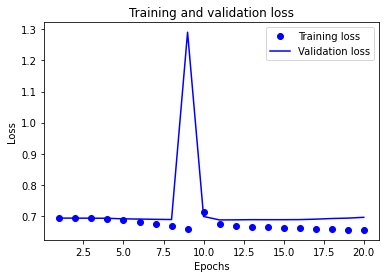

In [43]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- loss 를 통해 몇 에폿 까지의 학습이 적절한지 최적점을 추정할 수 있다.
- val_loss와 loss 의 이격이 발생하면 더 이상 학습이 무의미 하다.

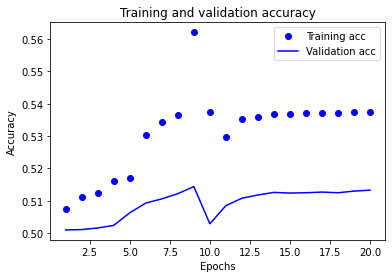

In [44]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

***
 상기 훈련에서 성능이 좋지 못했다. 에폭을 100까지 증가해보자
***

In [46]:
# 상기 훈련에서 성능이 좋지 못했다. 에폭을 증가해보자
# 옵티마이저 아담, 로스함수는 2진 분류이므로 바이너리 크로스엔트로피 사용.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/100
30/30 [==============================] - 3s 45ms/step - loss: 0.6544 - accuracy: 0.5307 - val_loss: 0.7011 - val_accuracy: 0.5134
Epoch 2/100
30/30 [==============================] - 1s 29ms/step - loss: 0.6532 - accuracy: 0.5373 - val_loss: 0.7067 - val_accuracy: 0.5127
Epoch 3/100
30/30 [==============================] - 1s 29ms/step - loss: 0.6522 - accuracy: 0.5338 - val_loss: 0.7068 - val_accuracy: 0.5150
Epoch 4/100
30/30 [==============================] - 1s 29ms/step - loss: 0.6515 - accuracy: 0.5339 - val_loss: 0.7120 - val_accuracy: 0.5123
Epoch 5/100
30/30 [==============================] - 1s 29ms/step - loss: 0.6519 - accuracy: 0.5325 - val_loss: 0.7113 - val_accuracy: 0.5105
Epoch 6/100
30/30 [==============================] - 1s 29ms/step - loss: 0.6511 - accuracy: 0.5270 - val_loss: 0.7185 - val_accuracy: 0.5105
Epoch 7/100
30/30 [==============================] - 1s 29ms/step - loss: 0.6501 - accuracy: 0.5384 - val_loss: 0.7255 - val_accuracy: 0.5111
Epoch 

782/782 - 5s - loss: 0.7740 - accuracy: 0.5114
[0.7740244269371033, 0.5114399790763855]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


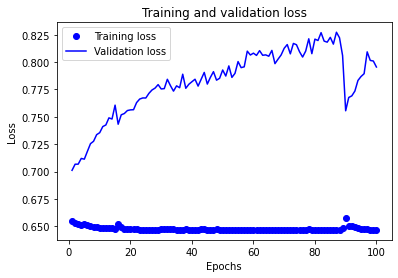

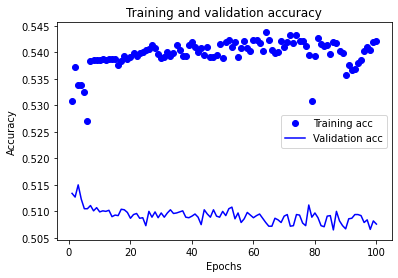

In [47]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)
print()
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

plt.clf()   # 그림을 초기화합니다
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

/앞선 에폭 20에서 에폭에 따른 성능 향상을 관찰 할 수 없었다. 따라서 에폭을 100으로 변경하여 다시 학습해 보았다./

[해석]
- loss 는 에폭이 증가함에 따라 큰변화가 없다.
- val_loss 는 구준히 증가 한다.
- acc 는 0.54 근처에서 튄다.
- val_acc 는 0.51에서 0.50으로 튀며 감소 한다.
> acc 가 0.51 로 단순이 찍은 확률과 같은 성능이다. 에폭을 늘려도 학습이 되지 않기에 언더피팅되었다고 해석할 수 있다. 에폭이 아니라 데이터셋이나, 모델 구조의 개선을 시도할 필요가 있다.
***

### 2.3 IMDB 영화리뷰 감성분석_Word2Vec 적용
- 이전 과정에서 워드 임베딩을 사용하였다.
- 단어의 특성을 저차원 벡터값으로 표현한다.
- 임베딩 레이어는 (단어사전의 개수 x 워드벡터 사이즈) 크기의 학습 파라미터를 갖는 레이어였다.
- 학습이 잘 되었다면, 학습된 워드 벡터들도 **'의미 공간상'에 유의미한 형태**로 학습되었을 것이다.
- 확인해 보자.

In [48]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [49]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- gensim 의 패키지로, 상기 임베딩 파라미터를 읽어들여 word vector로 활용할 수 있다.

In [50]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.01174831,  0.00602984, -0.01110123, -0.05112463,  0.02092644,
       -0.04311644,  0.05319917, -0.0362718 ,  0.04535187,  0.06950343,
        0.05928158,  0.06730494, -0.00212136,  0.09066048,  0.00599825,
       -0.02536545], dtype=float32)

- 워드 벡터가 의미 공간상 유의미하게 학습되었는지 확인하는 방법으로 gensim을 사용하여 가장 유사한 단어를 확인하는 방법이 있다.

In [51]:
word_vectors.similar_by_word("love")

[("can't", 0.7816762328147888),
 ('yourself', 0.7625768184661865),
 ('stopping', 0.7609211802482605),
 ('future', 0.7497736811637878),
 ('still', 0.74878990650177),
 ('musicals', 0.7425988912582397),
 ('us', 0.7413322329521179),
 ('superior', 0.736118495464325),
 ('not', 0.734872043132782),
 ('woefully', 0.7330211400985718)]

- love 라는 단어와 유사한 단어를 찾았다고 판단되지 않는다.
- 감성분류 문제를 잠깐 학습한것으로  워드 벡터가 유의미하게 학습되기는 어려워 보인다.
- 훈련데이터가 부족한 이유일 것이다.
- 구글에서 제공하는 Word2Vec 이라는 사전학습된(pretrained) 워드 임베딩모데을 가져다 활용해 보자.
> [Word2Vec] : 1억개의 단어로 구성된 구글 뉴스 데이터를 바탕으로 학습. 300만개 단어를 300차원 벡터로 표현한것, 

- 이와 같이 사전에 학습된 임베딩을 활용하는 것이 유리하다.
[참고] :https://ratsgo.github.io/natural%20language%20processing/2019/09/12/embedding/

In [52]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

- 300 차원의 단어가 300 만개이다.
- 모두 로딩한다면 시습환경 에러가 날것이다.
- 워드 벡터 단어중 사용빈도가 높은 100만개로 limit 조건을 주어 로딩했다.
- 메모리가 충분하다면 limit = None 으로 로딩하면 된다

In [56]:
# 다시 유사한 단어를 출력해보자
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

- 꽤나 의미적 유사도가 가까운 단어들이 확인되었다.
- 학습이 잘된 임베딩이다.
- 학습했던 모델의 임베딩 레이어를 Word2Vec으로 교체하여 다시 학습해보자.

In [57]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [58]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [59]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 16s 84ms/step - loss: 0.6830 - accuracy: 0.5625 - val_loss: 0.6659 - val_accuracy: 0.6036
Epoch 2/20
30/30 [==============================] - 2s 66ms/step - loss: 0.6267 - accuracy: 0.6668 - val_loss: 0.5896 - val_accuracy: 0.7152
Epoch 3/20
30/30 [==============================] - 2s 66ms/step - loss: 0.5029 - accuracy: 0.7801 - val_loss: 0.4423 - val_accuracy: 0.8082
Epoch 4/20
30/30 [==============================] - 2s 66ms/step - loss: 0.3436 - accuracy: 0.8633 - val_loss: 0.3443 - val_accuracy: 0.8512
Epoch 5/20
30/30 [==============================] - 2s 66ms/step - loss: 0.2523 - accuracy: 0.8999 - val_loss: 0.3205 - val_accuracy: 0.8627
Epoch 6/20
30/30 [==============================] - 2s 67ms/step - loss: 0.1841 - accuracy: 0.9363 - val_loss: 0.3222 - val_accuracy: 0.8662
Epoch 7/20
30/30 [==============================] - 2s 67ms/step - loss: 0.1478 - accuracy: 0.9505 - val_loss: 0.3106 - val_accuracy: 0.8705
Epoch 8/20
3

In [60]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 2s - loss: 0.5402 - accuracy: 0.8596
[0.5402491688728333, 0.8595600128173828]


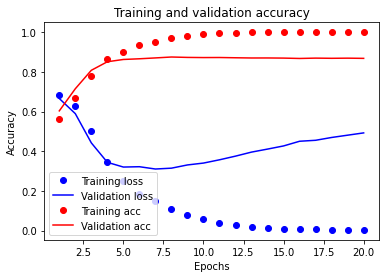

In [62]:
history_dict = history.history

import matplotlib.pyplot as plt

plt.clf()   # 그림을 초기화합니다
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

[Word2Vec 을 임베딩으로 사용한 결과]
- loss, acc, val_loss, val_acc 모두 크개 개선되었다.
- acc는 10 에폭 이후 0.99에 수렴하고 있다.
- val_acc는 4 에폭 이후 0.87에 수렴하고 있다.
- loss는 13 에폭 이후 0.004까지 감소하고 있으며
- val_loss 는 3 ~ 7 에폭에서 최저를 찍고, 이후 다시 꾸준히 증가하고 있다.
- 테스트 셋의 acc 와 loss 는 각각 0.859, 0.540 이다.

[해석]
- 에폭 7이후 오버피팅되었다고 해석할 수 있다.
- 3~7에폭 사이의 모델을 사용하는 것이 가장 합리적이다.

[힝]
- Word2Vec을 잘 활용하면 5% 이상 성능 향상 한다고 한다. 
> **적절한 모델 구성, 하이퍼 파라미터를 고려하여 감성분석 모델의 성능을 최대한으로 끌어올려 보자**
***

## 3 프로젝트 : 네이버 영화리뷰 감성분석
[프로젝트 시작 전 루브릭 확인!]

|평가문항|상세기준|
|:------|:---|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|**3가지 이상의 모델**이 성공적으로 시도됨|
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 **정확도를 85%** 이상 달성함|

### 3.1 프로젝트 : 네이버 영화리뷰 감성분석_데이터 준비와 확인
- 한국어 텍스트 감성분석을 해보자.
- 네이버 영화의 댓글로 구성된 데이터이다.
[데이터셋] : https://github.com/e9t/nsmc

In [13]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [14]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(train_data), len(test_data)))

훈련 샘플 개수: 150000, 테스트 개수: 50000


In [15]:
print('훈련셋 비율')
print(train_data['label'].value_counts())
print(train_data['label'].value_counts()[0]/train_data['label'].value_counts()[1])


훈련셋 비율
0    75173
1    74827
Name: label, dtype: int64
1.0046239993585204


In [16]:
print('테스트셋 비율')
print(test_data['label'].value_counts())
print(test_data['label'].value_counts()[0]/test_data['label'].value_counts()[1])

테스트셋 비율
1    25173
0    24827
Name: label, dtype: int64
0.9862551146069201


[데이터 확인]
- 데이터는 id, document,label 3개 컬럼을 구성되어 있다.
- 앞의 데이터셋과 마찬가지로 0 : 부정, 1 : 긍정 리뷰로 라벨되어있다.
- 훈련 데이터 15만개, 테스트 데이터 5만개 이다.
- 긍정 부정 비율이 약 1로 비슷하다.
- 앞선 검증 데이터 분리에서 40%(2만5천 중 1만개)를 검증 데이터로 분리했다.
- 검증 데이터로 15만개 훈련데이터 중 5만개를 사용하자.(33%)
***

### 3.2 프로젝트 : 네이버 영화리뷰 감성분석_데이터로더 구성
- 실습 IMDB 데이터 셋과 달리, 이번 데이터 셋은 전혀 가공되어있지 않다.
- 상기 imdb.data_loader() 와 동일하게 작동하는 data_loader를 만들자.
- data_loader에서는 다음을 수행한다.
> 1. 데이터의 중복 제거
> 2. NaN 결측치 제거
> 3. 한국어 토크나이저로 토큰화
> 4. 불용어(Stopwords) 제거
> 5. 사전word_to_index 구성
> 6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
> 7. X_train, y_train, X_test, y_test, word_to_index 리턴

토크나이저로 메캅 형태소 분석기를 사용한다.

> [메캅? Mecab?] : [참고] : https://konlpy-ko.readthedocs.io/ko/v0.4.3/api/konlpy.tag/#mecab-class
> - 교토대학교 정보대학원에서 개발한 일본어 형태소 분석기이자 POS 태거 이다.
> - 은전프로젝트를 통해 한국어 버전으로 수정되었다.

> [POS tagger?] : [참고] : https://m.blog.naver.com/bycho211/221893460325
> - POS tagger 는 형태소 분석기와 같은 말이다.
> - 원시 말뭉치(Corpus)를 형태소 단위로 쪼개고 각 형태소에 품사 정보를 부착하는 작업을 POS-tagging 이라 한다.


- 한국어 형태소 분석기(품사 태그 정리, 형태소 분석기 비교) 참고 : https://velog.io/@metterian/series/%ED%95%9C%EA%B5%AD%EC%96%B4-%ED%98%95%ED%83%9C%EC%86%8C-%EB%B6%84%EC%84%9D%EA%B8%B0POS


In [17]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab() 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 1. 데이터 중복 제거
    train_data = train_data.dropna(how = 'any')  # 2. 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # 1. 데이터 중복 제거
    test_data = test_data.dropna(how = 'any') # 2. 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 3. 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 4. 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 3. 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 4. 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) # 1만개 단어사전인데, PAD, BOS, UNK, UNUSED가 추가된다.
    
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # PAD, BOS, UNK, UNUSED 추가
    word_to_index = {word:index for index, word in enumerate(vocab)} # 5. 사전  word_to_index 구성
        
    def wordlist_to_indexlist(wordlist): 
        # <BOS>의 인덱스를  문장 앞 추가
        # 단어사전에 있으면 index 변환, 없으면(else) '<UNK>' 의 인덱스로 된 리스트를 반환.
        return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    # 6. 텍스트 스트링을 사전 인덱스 스트링을 변환
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    # 7. 훈련셋, 테스트셋, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)



In [18]:

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 5232, 2, 2]


In [19]:
# word to index를 index to word로 변환
index_to_word = {index:word for word, index in word_to_index.items()}

In [20]:
index_to_word.items()

dict_items([(0, '<PAD>'), (1, '<BOS>'), (2, '<UNK>'), (3, '<UNUSED>'), (4, '.'), (5, '영화'), (6, '다'), (7, '고'), (8, '하'), (9, '을'), (10, '보'), (11, '..'), (12, '게'), (13, ','), (14, '!'), (15, '지'), (16, '있'), (17, '없'), (18, '?'), (19, '좋'), (20, '나'), (21, '었'), (22, '만'), (23, '는데'), (24, '너무'), (25, '봤'), (26, '적'), (27, '안'), (28, '정말'), (29, '로'), (30, '음'), (31, '것'), (32, '아'), (33, '네요'), (34, '재밌'), (35, '어'), (36, '같'), (37, '점'), (38, '지만'), (39, '진짜'), (40, '했'), (41, '에서'), (42, '기'), (43, '네'), (44, '않'), (45, '거'), (46, '았'), (47, '수'), (48, '되'), (49, '면'), (50, 'ㅋㅋ'), (51, '말'), (52, '연기'), (53, '인'), (54, '주'), (55, '내'), (56, '최고'), (57, '~'), (58, '평점'), (59, '이런'), (60, '던'), (61, '어요'), (62, '할'), (63, '왜'), (64, '겠'), (65, '1'), (66, '스토리'), (67, '해'), (68, '습니다'), (69, 'ㅋㅋㅋ'), (70, '...'), (71, '드라마'), (72, '생각'), (73, '아니'), (74, '더'), (75, '그'), (76, '싶'), (77, '사람'), (78, '듯'), (79, '때'), (80, '감동'), (81, '함'), (82, '배우'), (83, '본'), (84, '까지'), (85, '뭐'), (

In [21]:
# 토큰화 된 문장을 확인하자.훈련셋 확인하기
decoded_sentences = get_decoded_sentences(X_train, index_to_word)
print(decoded_sentences[0:3])

['아 더 빙 . . 진짜 짜증 나 네요 목소리', '흠 . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나', '너무 재 <UNK>']


In [22]:
X_train[0:3]

[[1, 32, 74, 919, 4, 4, 39, 228, 20, 33, 748],
 [1,
  1028,
  4,
  11,
  519,
  549,
  687,
  5,
  120,
  4,
  70,
  1639,
  52,
  925,
  1006,
  15,
  44,
  391],
 [1, 24, 205, 2]]

- ***LMS 코드만 따라가다가, '&#60;PAD>', '&#60;BOS>', '&#60;UNK>', '&#60;UNUSED>' 가 단어사전에 없어서 당황했다.***
- 하지만, 예시 답안의 빈칸을 힌트로 수정할 부분을 알 수 있었다.
- 수정 후, 1 : '&#60;BOS>' 와 2:'&#60;UNK>' 가 잘 나온다.
- 인코딩이 잘 되었다.

### 3.3 프로젝트 : 네이버 영화리뷰 감성분석_모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [23]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test) # 전체 문장을 담는다. 
# 텍스트 데이터 문장길이의 리스트를 생성한 후 
num_tokens = [len(tokens) for tokens in total_data_text] #전체 문장에서 각 문장의 길이를 담은 리스트 생성.
num_tokens = np.array(num_tokens) # np 연산을 위해, np.array로 변환.

# 문장길이의 편균, max, 표준편차를 계산.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  16.96940191154864
문장길이 최대 :  117
문장길이 표준편차 :  12.843571191092


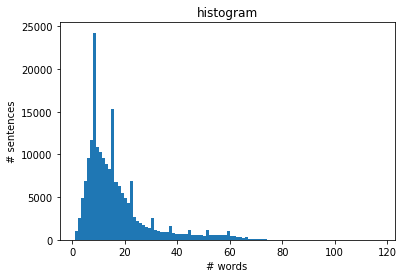

In [24]:
# 데이터셋 내 문장 길이 분포

# 히스토 그램으로 문장길이 분포 시각화
from matplotlib import pyplot as plt 

plt.hist(num_tokens, bins = 100) 
plt.title("histogram") 
plt.xlabel('# words') 
plt.ylabel('# sentences')
plt.show()

In [26]:
# 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  42
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


[최대 문장 길이 지정]
- 상기 예제와 동일 하게 maxlen을 평균 + 2*표준편차로 지정하자.
- maxlen 은 42 이다.

In [27]:
# 훈련셋과 테스트 셋에 maxlen으로 자르고, 패팅을 주자.
# 이번에는 앞서 훈련 성능이 더 좋다고 한 pre로 앞에 패딩을 주었다.
# 이번에는 앞
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 42)
(49157, 42)


- 중복을 제거하니 훈련셋 테스트셋 각각 약 14만 6천개, 4만 9천개 가량으로 감소 하였지만, 적은 비중이므로 괜찮다.

### 3.4 프로젝트 : 네이버 영화리뷰 감성분석_모델 구성 및 validation set 구성
- 모델은 3가지 이상 다양하게 구성하자
- 앞선 검증 데이터 분리에서 40%(2만5천 중 1만개)를 검증 데이터로 분리했다.
- 검증 데이터로 40% 분리하자.

In [28]:
from sklearn.model_selection import train_test_split
# stratify 를 주어 분할 후 클래스 비율이 유지되도록 하자
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.4, random_state=42)

In [29]:
def get_class_ratio(y):
    _, arr = np.unique(y, return_counts = True)
    print(arr, '비율: ',arr[0]/arr[1])
    
print('훈련셋 비율')
get_class_ratio(partial_y_train)
print('검증셋 비율')
get_class_ratio(y_val)

훈련셋 비율
[44005 43704] 비율:  1.0068872414424308
검증셋 비율
[29337 29136] 비율:  1.0068986820428336


In [30]:
print('훈련셋 크기')
print(partial_x_train.shape)
print('검증셋 크기')
print(x_val.shape)

훈련셋 크기
(87709, 42)
검증셋 크기
(58473, 42)


- 클래스 비율이 약 1로 일정하게 잘 나누어졌다.
- 훈련셋 약 8만7천개, 검증셋 약 5만8천개이다.
***

### 3.5 프로젝트 : 네이버 영화리뷰 감성분석_훈련, loss/acc 시각화, 임베딩 학습 분석
> - 모델 훈련 개시
> - Loss, Acc 그래프 시각화
> - 학습된 임베딩 분석

#### 첫번째 모델 : 앞서 사용한 LSTM 모델에 임베딩 차원을 100으로 키웠다.

In [167]:

# 
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))# state 벡터 차원서 8, 변경가능
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))#최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [168]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
172/172 [==============================] - 3s 12ms/step - loss: 0.5352 - accuracy: 0.7631 - val_loss: 0.4075 - val_accuracy: 0.8390
Epoch 2/20
172/172 [==============================] - 1s 7ms/step - loss: 0.3575 - accuracy: 0.8571 - val_loss: 0.3633 - val_accuracy: 0.8464
Epoch 3/20
172/172 [==============================] - 1s 7ms/step - loss: 0.3107 - accuracy: 0.8753 - val_loss: 0.3581 - val_accuracy: 0.8438
Epoch 4/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2868 - accuracy: 0.8844 - val_loss: 0.3553 - val_accuracy: 0.8485
Epoch 5/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2662 - accuracy: 0.8928 - val_loss: 0.3685 - val_accuracy: 0.8469
Epoch 6/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2478 - accuracy: 0.9018 - val_loss: 0.3712 - val_accuracy: 0.8466
Epoch 7/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2277 - accuracy: 0.9098 - val_loss: 0.3936 - val_accuracy: 0.8444
Epoch

In [61]:
# 테스트셋을 통한 모델 평가 및 학습 시각화 함수화

def eval_model(model, X_test, y_test):
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(results)
    
import matplotlib.pyplot as plt

def visual_history(history):
    history_dict = history.history

    plt.clf()   # 그림을 초기화합니다
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.plot(epochs, acc, 'ro', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [62]:
# word2vec 만들고 저장 함수화
def save_w2v(word2vec_file_path, vocab_size, word_vector_dim):
    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 

    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 불러오기
def read_w2v(word2vec_file_path):
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    return word_vectors

In [173]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vecM1.txt' # 모델1 : M1
save_w2v(word2vec_file_path, vocab_size, word_vector_dim)
read_w2v(word2vec_file_path).similar_by_word("사랑")

[('색다른', 0.8567714691162109),
 ('은대', 0.8330176472663879),
 ('놀란', 0.8312519192695618),
 ('충실', 0.8281551003456116),
 ('찬사', 0.8268294930458069),
 ('소장', 0.8261317014694214),
 ('주일', 0.825094997882843),
 ('슬펐', 0.8240748643875122),
 ('멋있', 0.8239524364471436),
 ('떠서', 0.8219249844551086)]

In [156]:
eval_model(model, X_test, y_test)

1537/1537 - 3s - loss: 0.7218 - accuracy: 0.8227
[0.7218298316001892, 0.8226702213287354]


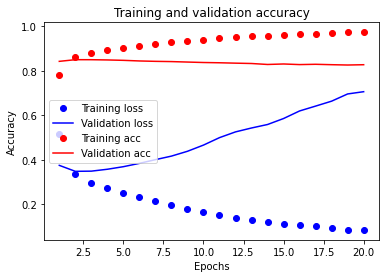

In [157]:
visual_history(history)

[결과] : **임베딩차원 :100** , 에폭 20, batch_size=512, state 벡터 차원 : 8
- 테스트 정확도 0.8226이다.
- acc 꾸준히 증가, val_acc 미소하게 감소
- loss 꾸준히 감소, val_loss 2 에폭 부터 증가.
- val_acc 최대 0.845


[해석]
- val_acc 0.845로 테스트 정확도 기준 0.85에 가깝게 나타났지만 모자란다.
- 정확도는 0.8 수준으로 나왔으나, 초기 에폭 이후 학습을 거듭하여도 성능이 향상되지 않음.
- 에폭 2부터 val_acc 증가 없이 val_loss 가 증가하여 오버피팅이 예상된다.
- 사랑과 유사한 단어 목록이 다소 애매한듯 하다. 확실히 사랑과 연관된 단어(찬사, 멋있)도 있지만, 앞선 Word2Vec 에서 love와 유사한 단어를 확인했을때 만큼 확실하게 유사한 단어나오진 않았다. 의미 공간상 학습이 부족하다고 판단된다.

#### 두번째 모델 : 첫번째 모델에서 state 벡터 차원을 키워보자.

In [174]:

# 
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16)) # state 벡처 차원 16으로 변경
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))#최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 1,007,633
Trainable params: 1,007,633
Non-trainable params: 0
_________________________________________________________________


In [175]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
172/172 [==============================] - 3s 9ms/step - loss: 0.4697 - accuracy: 0.7904 - val_loss: 0.3622 - val_accuracy: 0.8447
Epoch 2/20
172/172 [==============================] - 1s 7ms/step - loss: 0.3315 - accuracy: 0.8605 - val_loss: 0.3529 - val_accuracy: 0.8470
Epoch 3/20
172/172 [==============================] - 1s 7ms/step - loss: 0.3026 - accuracy: 0.8750 - val_loss: 0.3508 - val_accuracy: 0.8472
Epoch 4/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2809 - accuracy: 0.8852 - val_loss: 0.3556 - val_accuracy: 0.8458
Epoch 5/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2595 - accuracy: 0.8943 - val_loss: 0.3679 - val_accuracy: 0.8485
Epoch 6/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2379 - accuracy: 0.9033 - val_loss: 0.3822 - val_accuracy: 0.8435
Epoch 7/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2170 - accuracy: 0.9125 - val_loss: 0.4025 - val_accuracy: 0.8452
Epoch 

In [176]:
eval_model(model, X_test, y_test)

1537/1537 - 3s - loss: 0.8018 - accuracy: 0.8285
[0.8018162250518799, 0.828549325466156]


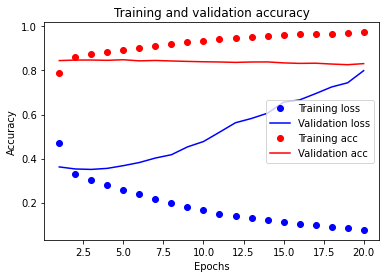

In [177]:
visual_history(history)

In [178]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vecM2.txt' # 모델1 : M1
save_w2v(word2vec_file_path, vocab_size, word_vector_dim)
read_w2v(word2vec_file_path).similar_by_word("사랑")

[('소울', 0.8848583102226257),
 ('모델', 0.8816930651664734),
 ('원제', 0.8792485594749451),
 ('명작', 0.8775777816772461),
 ('소장', 0.8754878640174866),
 ('완벽', 0.8744290471076965),
 ('재미있', 0.8732012510299683),
 ('흥미진진', 0.8711851835250854),
 ('빠져', 0.8614887595176697),
 ('소주', 0.8535388708114624)]

[결과] : 임베딩차원 :100 , 에폭 20, batch_size=512, **state 벡터 차원 : 16**
- 테스트 정확도 0.8285이다.
- acc 꾸준히 증가, val_acc 미소하게 감소
- loss 꾸준히 감소, val_loss 2 에폭 부터 증가.
- val_acc 최대 0.848
- 학습된 임베딩 벡터를 살펴본 결과, **사랑**과 유사한 단어로 **소울, 모델, 원제, 명작, 소장, 완벽, 재미있, 흥미진진, 바져, 소주**가 나왔다.

[해석]
- val_acc 0.848로 테스트 정확도 기준 0.85에 가깝게 나타났지만 모자란다.
- val_acc는 0.83 수준으로 나왔으나, 초기 에폭 이후 학습을 거듭하여도 성능이 향상되지 않음.
- 에폭 2부터 val_acc 증가 없이 val_loss 가 증가하여 오버피팅이 예상된다.
- state 벡터 차원 증가가 크게 효과가 없다고 해석 된다.
- 사랑과 유사한 단어 목록이 개선되었다. 확실히 사랑과 연관된 단어 혹은 긍정적 단어(명작, 소장, 완벽, 재미있, 흥미진진)가 나왔다. 하지만 역시 애매한 단어들도 있고, 앞선 Word2Vec 에서 love와 유사한 단어를 확인했을때 만큼 확실하게 유사한 단어는 나오진 않았다. 의미 공간상 학습이 다소 부족하다고 판단된다.

#### 세번째 모델 : Word2Vec을 사용한 1D Conv를 사용해보자.

In [179]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [180]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
172/172 [==============================] - 2s 7ms/step - loss: 0.5018 - accuracy: 0.7424 - val_loss: 0.3733 - val_accuracy: 0.8318
Epoch 2/20
172/172 [==============================] - 1s 6ms/step - loss: 0.3273 - accuracy: 0.8595 - val_loss: 0.3572 - val_accuracy: 0.8402
Epoch 3/20
172/172 [==============================] - 1s 6ms/step - loss: 0.2694 - accuracy: 0.8907 - val_loss: 0.3643 - val_accuracy: 0.8392
Epoch 4/20
172/172 [==============================] - 1s 6ms/step - loss: 0.2074 - accuracy: 0.9214 - val_loss: 0.4002 - val_accuracy: 0.8351
Epoch 5/20
172/172 [==============================] - 1s 6ms/step - loss: 0.1452 - accuracy: 0.9492 - val_loss: 0.4493 - val_accuracy: 0.8307
Epoch 6/20
172/172 [==============================] - 1s 6ms/step - loss: 0.0989 - accuracy: 0.9671 - val_loss: 0.5076 - val_accuracy: 0.8276
Epoch 7/20
172/172 [==============================] - 1s 6ms/step - loss: 0.0691 - accuracy: 0.9772 - val_loss: 0.5924 - val_accuracy: 0.8264
Epoch 

In [181]:
eval_model(model, X_test, y_test)

1537/1537 - 3s - loss: 1.2020 - accuracy: 0.8099
[1.2020076513290405, 0.8099355101585388]


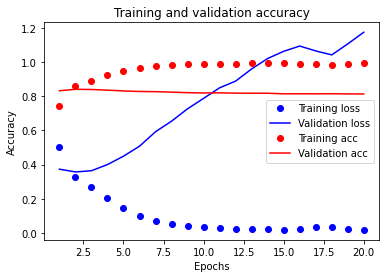

In [182]:
visual_history(history)

In [183]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vecM3.txt' # 모델1 : M1
save_w2v(word2vec_file_path, vocab_size, word_vector_dim)
read_w2v(word2vec_file_path).similar_by_word("사랑")

[('빠짐', 0.7066069841384888),
 ('두세', 0.6865543723106384),
 ('재발견', 0.6723327040672302),
 ('콜린파렐', 0.6721801161766052),
 ('풍성', 0.6687554717063904),
 ('정점', 0.6595333814620972),
 ('이만', 0.6588178873062134),
 ('탐', 0.6583957076072693),
 ('멋져요', 0.6568005681037903),
 ('리딕', 0.6546502113342285)]

[결과] : 임베딩차원 :100 , 에폭 20, batch_size=512, **1D-conv 모델**
- 테스트 정확도 0.8099이다.
- acc 꾸준히 증가, val_acc 미소하게 감소
- loss 꾸준히 감소, val_loss 2 에폭 부터 증가.
- val_acc 최대 0.8411
- 학습된 임베딩 벡터를 살펴본 결과, **사랑**과 유사한 단어로 **빠짐, 두세, 재발견, 콜린파렐, 풍성, 정점, 이만, 탐, 멋져요, 리딕**가 나왔다.

[해석]
- val_acc 0.8402 로 테스트 정확도 기준 0.85에 가깝게 나타났지만 모자란다.
- val_acc는 0.81 수준으로 나왔으나, 초기 에폭 이후 학습을 거듭하여도 성능이 향상되지 않음.
- 에폭 2부터 val_acc 증가 없이 val_loss 가 증가하여 오버피팅이 예상된다.
- 사랑과 유사한 단어 목록이 앞선 모델보다 더 부정확해 보인다. 그나마 사랑과 연관된 단어(풍성, 정점, 멋져요)가 있지만, 앞선 두번째 모델의 단어들과 비교해 볼때 많이 차이가 난다. 의미 공간상 학습이 많이 부족하다고 판단된다.
- 1-D conv 모델은 정확도는 첫번째 두번째 (RNN)모델과 유사하게 나왔지만, 실제 임베딩 학습의 성능은 많이 부족하다고 판단된다.

### 3.6 프로젝트 : 네이버 영화리뷰 감성분석_한국어 Word2Vec으로 성능 개선
> - 학습된 Word2Vec ko.bin을 가져온다.
> - gensim 버전 3.8.3
> - vector_size = 200, coupus_size = 339M, vocabulary_size = 30185 이다.
> - [참고자료]: https://github.com/Kyubyong/wordvectors

In [199]:
!pip install --upgrade gensim==3.8.3

In [31]:
from gensim.models import KeyedVectors
import gensim
gensim.__version__

'3.8.3'

In [91]:
ko_word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_word2vec = gensim.models.Word2Vec.load(ko_word2vec_path)
ko_vector = ko_word2vec.wv['사랑']
ko_vector     # 무려 200dim의 워드 벡터입니다.

array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [92]:
ko_word2vec.wv.similar_by_word("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

- 한글 Word2Vec 를 불러와 '사랑' 과 유사한 단어를 보니 연관된 단어들을 확인할 수 있다.
- 학습해보자.

In [93]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_word2vec.wv:
        embedding_matrix[i] = ko_word2vec.wv[index_to_word[i]]

- 앞서 영어 Word2vec을 가져와 사용한 모델과 같은 모델로 먼저 해보자

#### 네번째 모델 : 한글 w2v적용, 1D-conv

In [94]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 42, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 36, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [95]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
172/172 [==============================] - 2s 8ms/step - loss: 0.5870 - accuracy: 0.6736 - val_loss: 0.4923 - val_accuracy: 0.7628
Epoch 2/20
172/172 [==============================] - 1s 7ms/step - loss: 0.4392 - accuracy: 0.7967 - val_loss: 0.4275 - val_accuracy: 0.8047
Epoch 3/20
172/172 [==============================] - 1s 7ms/step - loss: 0.3710 - accuracy: 0.8363 - val_loss: 0.4033 - val_accuracy: 0.8146
Epoch 4/20
172/172 [==============================] - 1s 7ms/step - loss: 0.3246 - accuracy: 0.8620 - val_loss: 0.3919 - val_accuracy: 0.8249
Epoch 5/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2883 - accuracy: 0.8801 - val_loss: 0.3950 - val_accuracy: 0.8282
Epoch 6/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2587 - accuracy: 0.8956 - val_loss: 0.4076 - val_accuracy: 0.8253
Epoch 7/20
172/172 [==============================] - 1s 7ms/step - loss: 0.2320 - accuracy: 0.9085 - val_loss: 0.4292 - val_accuracy: 0.8248
Epoch 

In [96]:
eval_model(model, X_test, y_test)

1537/1537 - 3s - loss: 0.9370 - accuracy: 0.8083
[0.9369605779647827, 0.8082877397537231]


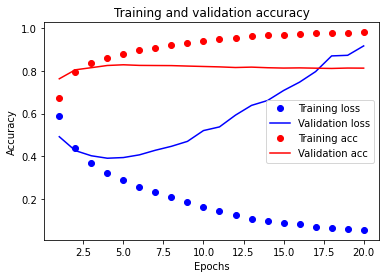

In [97]:
visual_history(history)

In [98]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vecM4.txt' # 모델4
save_w2v(word2vec_file_path, vocab_size, word_vector_dim)
read_w2v(word2vec_file_path).similar_by_word("사랑")

[('슬픔', 0.7047433257102966),
 ('행복', 0.6705141067504883),
 ('절망', 0.6359759569168091),
 ('기쁨', 0.6349973678588867),
 ('애정', 0.631896436214447),
 ('이별', 0.6288449764251709),
 ('추억', 0.6244515180587769),
 ('인생', 0.6210952997207642),
 ('연인', 0.6203098297119141),
 ('고독', 0.6109744906425476)]

#### 다섯번째 모델 : 한글 w2v적용, lstm 16

In [117]:
# 임베딩 메트릭스 초기화
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_word2vec.wv:
        embedding_matrix[i] = ko_word2vec.wv[index_to_word[i]]

In [118]:
# 
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(16)) # state 벡처 차원 16으로 변경
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))#최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 42, 200)           2000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [120]:
# 학습의 진행, 얼리스탑 추가
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, mode = 'auto')

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks = [early_stopping],
                    verbose=1)

Epoch 1/20
172/172 [==============================] - 3s 10ms/step - loss: 0.2080 - accuracy: 0.9195 - val_loss: 0.3979 - val_accuracy: 0.8482
Epoch 2/20
172/172 [==============================] - 1s 8ms/step - loss: 0.1922 - accuracy: 0.9272 - val_loss: 0.4009 - val_accuracy: 0.8445
Epoch 3/20
172/172 [==============================] - 1s 8ms/step - loss: 0.1824 - accuracy: 0.9313 - val_loss: 0.4160 - val_accuracy: 0.8451


In [121]:
eval_model(model, X_test, y_test)

1537/1537 - 3s - loss: 0.4270 - accuracy: 0.8417
[0.4269861876964569, 0.8416502475738525]


#### 여섯번째 모델 : 한글 w2v적용, lstm, dropout 추가

In [128]:
# 임베딩 메트릭스 초기화
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_word2vec.wv:
        embedding_matrix[i] = ko_word2vec.wv[index_to_word[i]]

In [129]:
from tensorflow.keras.layers import Dropout
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(32, dropout= 0.2,  recurrent_dropout=0.2)) # state 벡처 차원 16으로 변경

model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))#최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 42, 200)           2000000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                29824     
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 2,030,097
Trainable params: 2,030,097
Non-trainable params: 0
_________________________________________________________________


In [130]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 1, mode = 'auto')

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks = [early_stopping],
                    verbose=1)

Epoch 1/20
172/172 [==============================] - 35s 186ms/step - loss: 0.6391 - accuracy: 0.6574 - val_loss: 0.5526 - val_accuracy: 0.7824
Epoch 2/20
172/172 [==============================] - 31s 183ms/step - loss: 0.5307 - accuracy: 0.7919 - val_loss: 0.4861 - val_accuracy: 0.8245
Epoch 3/20
172/172 [==============================] - 31s 183ms/step - loss: 0.4723 - accuracy: 0.8267 - val_loss: 0.4539 - val_accuracy: 0.8375
Epoch 4/20
172/172 [==============================] - 31s 182ms/step - loss: 0.4330 - accuracy: 0.8436 - val_loss: 0.4273 - val_accuracy: 0.8441
Epoch 5/20
172/172 [==============================] - 31s 182ms/step - loss: 0.4038 - accuracy: 0.8561 - val_loss: 0.4124 - val_accuracy: 0.8473
Epoch 6/20
172/172 [==============================] - 31s 182ms/step - loss: 0.3778 - accuracy: 0.8640 - val_loss: 0.3981 - val_accuracy: 0.8483
Epoch 7/20
172/172 [==============================] - 31s 180ms/step - loss: 0.3585 - accuracy: 0.8710 - val_loss: 0.3948 - val_ac

In [131]:
eval_model(model, X_test, y_test)

1537/1537 - 19s - loss: 0.3979 - accuracy: 0.8521
[0.3979156017303467, 0.8520861864089966]


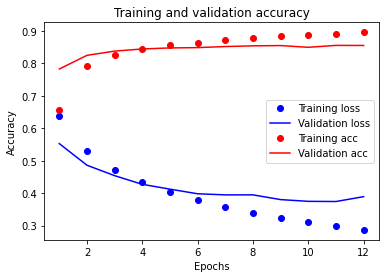

In [132]:
visual_history(history)

In [133]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vecM5.txt' # 모델6
save_w2v(word2vec_file_path, vocab_size, word_vector_dim)
read_w2v(word2vec_file_path).similar_by_word("사랑")

[('슬픔', 0.7265310287475586),
 ('행복', 0.6947134137153625),
 ('이별', 0.6423642039299011),
 ('인생', 0.6400826573371887),
 ('추억', 0.6357772350311279),
 ('기쁨', 0.6286667585372925),
 ('연인', 0.6218015551567078),
 ('절망', 0.6177339553833008),
 ('애정', 0.6121349930763245),
 ('고독', 0.6006474494934082)]

[결과] : 임베딩차원 :100 , 에폭 20, batch_size=512, **1D-conv 모델**
- 테스트 정확도 0.8099이다.
- acc 꾸준히 증가, val_acc 미소하게 감소
- loss 꾸준히 감소, val_loss 2 에폭 부터 증가.
- val_acc 최대 0.8411
- 학습된 임베딩 벡터를 살펴본 결과, **사랑**과 유사한 단어로 **빠짐, 두세, 재발견, 콜린파렐, 풍성, 정점, 이만, 탐, 멋져요, 리딕**가 나왔다.

[해석]
- val_acc 0.8402 로 테스트 정확도 기준 0.85에 가깝게 나타났지만 모자란다.
- val_acc는 0.81 수준으로 나왔으나, 초기 에폭 이후 학습을 거듭하여도 성능이 향상되지 않음.
- 에폭 2부터 val_acc 증가 없이 val_loss 가 증가하여 오버피팅이 예상된다.
- 사랑과 유사한 단어 목록이 앞선 모델보다 더 부정확해 보인다. 그나마 사랑과 연관된 단어(풍성, 정점, 멋져요)가 있지만, 앞선 두번째 모델의 단어들과 비교해 볼때 많이 차이가 난다. 의미 공간상 학습이 많이 부족하다고 판단된다.
- 1-D conv 모델은 정확도는 첫번째 두번째 (RNN)모델과 유사하게 나왔지만, 실제 임베딩 학습의 성능은 많이 부족하다고 판단된다.

### 4. 회고
- 어려웠던 점 : 
> 예시 코드 load_data 함수에서 '&#60;PAD>', '&#60;BOS>', '&#60;UNK>', '&#60;UNUSED>'가 단어사전에 없어서 수정하는 부분을 찾는라 조금 애먹었다.
> 한글 w2v없이 성능을 개선하고자 할 때 어떻게 해보아도 되지 않아 애먹었다.
> 한글 w2v 환경을 위해 버전과 파일을 읽을 load함수를 바꿔서 사용해야 했다.
> 한글 w2v 으로도 성능을 개선 하기 어려워 이것저것 해보았다.
- 알아낸점 : LSTM 층에 state 증가와 드롭아웃을 추가하는 것이 성능개선에 작은 도움이 되었다.
- 시도한 것 : lstm 모델과 1D-cnn 모델 여러가지 를 시도하였다. 유사단어를 확이하여 단순히 정확도가 아닌 의미공간상 학습이 잘되는지 살펴보았다. 함글 w2v을 적용하고, lstm 모델의 state 증가, 드롭아웃을 추가하였다. 얼리스타핑을 추가하여 최적의 성능을 주는 모델을 가져올수 있도록 했다.
- 자기 다짐 : 자연어가 매우 흥미로운 주제임에는 틀림 없다. 과정이 어려웠지만 가장 보람있는 익스였다. 스탑워드를 추가하는 개선을 시도하지 못해 아쉽다.
